## Importing Libraries 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import time
import string
import joblib

from bidi.algorithm import get_display
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud , ImageColorGenerator
from collections import Counter
import arabic_reshaper

import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff

from tqdm import tqdm
import gradio as gr
import os
from pprint import pprint 


from sklearn.linear_model import LogisticRegression, SGDClassifier, Perceptron
from sklearn.ensemble import VotingClassifier, StackingClassifier, AdaBoostClassifier,ExtraTreesClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV, learning_curve
from sklearn.metrics import accuracy_score, f1_score, classification_report , confusion_matrix ,precision_score, recall_score ,roc_curve, auc
from sklearn.utils import all_estimators


import tensorflow as tf 
from keras import layers 
from keras.layers import TextVectorization , LSTM , Embedding , Dense ,Input 
from keras.models import Model 
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
from tensorflow.keras.initializers import Constant
from keras import regularizers
from keras.models import load_model



# Suppress any warnings to keep the output clean
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load Arabic stopwords from the NLTK library
arabic_stopwords = stopwords.words('arabic')

# Create a list of punctuation marks to be removed from the text
punctuations = [punc for punc in string.punctuation]

# Set the style for matplotlib plots to 'seaborn' for better aesthetics
plt.style.use('seaborn-v0_8')

In [3]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 '_mpl-gallery',
 '_mpl-gallery-nogrid',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'petroff10',
 'seaborn-v0_8',
 'seaborn-v0_8-bright',
 'seaborn-v0_8-colorblind',
 'seaborn-v0_8-dark',
 'seaborn-v0_8-dark-palette',
 'seaborn-v0_8-darkgrid',
 'seaborn-v0_8-deep',
 'seaborn-v0_8-muted',
 'seaborn-v0_8-notebook',
 'seaborn-v0_8-paper',
 'seaborn-v0_8-pastel',
 'seaborn-v0_8-poster',
 'seaborn-v0_8-talk',
 'seaborn-v0_8-ticks',
 'seaborn-v0_8-white',
 'seaborn-v0_8-whitegrid',
 'tableau-colorblind10']

## Loading and preprocessing data 

In [4]:
df = pd.read_csv('Arabic Egypt Customer Reviews.csv')
df.head()

,review_description,rating,company
0,رائع,positive,talbat
1,برنامج رائع جدا يساعد على تلبيه الاحتياجات بشك...,positive,talbat
2,التطبيق لا يغتح دائما بيعطيني لا يوجد اتصال با...,negative,talbat
3,لماذا لا يمكننا طلب من ماكدونالدز؟,negative,talbat
4,البرنامج بيظهر كل المطاعم و مغلقه مع انها بتكو...,negative,talbat


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40046 entries, 0 to 40045
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   review_description  40045 non-null  object
 1   rating              40046 non-null  object
 2   company             40046 non-null  object
dtypes: object(3)
memory usage: 938.7+ KB


In [6]:
df.shape

(40046, 3)

In [7]:
# Check for any missing values in each column of the DataFrame
df.isnull().sum()

review_description    1
rating                0
company               0
dtype: int64

In [8]:
# dropping null data 
df.dropna(inplace=True)

In [9]:
# checking for duplicates 
df.duplicated().sum()

28

In [10]:
# dropping duplicates 
df.drop_duplicates(inplace=True)

In [11]:
# Count of reviews for each company in data 
df['company'].value_counts()

company
talbat           32071
swvl              4685
telecom_egypt     2090
venus              281
Raya               268
TMG                233
elsewedy           147
hilton             100
capiter             73
Ezz Steel           47
nestle              18
domty                4
Name: count, dtype: int64

## Exploratory Data Analysis (EDA)

In [12]:
# Count the number of reviews for each company in the dataset
companies_reviews_count = df['company'].value_counts().sort_values(ascending=False)
# Create a bar plot to visualize the count of reviews for each company
fig = px.bar(companies_reviews_count)
# Update the layout of the plot, setting the title for better context
fig.update_layout(title='Count of Reviews for each Company')
# Display the plot
fig.show() 

In [13]:
# Calculate the average rating for each company by grouping the data by 'company' and taking the mean of 'rating'
# Step 1: Convert rating to numeric (positive → 1, negative → -1)
df['numeric_rating'] = df['rating'].map({'positive': 1, 'negative': -1})

# Step 2: Group by company and take the mean of numeric_rating
companies_average_ratings = df.groupby('company')['numeric_rating'].mean().sort_values()

# Step 3: Convert to DataFrame
companies_average_ratings = companies_average_ratings.to_frame()

# Step 4: Create a new column 'Color' for bar coloring
companies_average_ratings['Color'] = companies_average_ratings['numeric_rating'].apply(
    lambda x: 'positive' if x >= 0 else 'negative'
)

# Step 5: Define color map
color_map = {'positive': 'green', 'negative': 'red'}
fig = px.bar(companies_average_ratings, 
             x=companies_average_ratings.index, 
             y='numeric_rating', 
             color='Color', 
             color_discrete_map=color_map)

fig.update_layout(title='Average Sentiment Rating per Company')
fig.show()


In [14]:
from plotly.subplots import make_subplots
# Step 1: Aggregate rating counts per company
ratings_count = df.groupby(['company', 'rating']).size().reset_index(name='count')

# Step 2: Get unique companies
companies = ratings_count['company'].unique()

# Step 3: Layout settings
n_cols = 3
n_rows = -(-len(companies) // n_cols)  # Ceiling division

# Step 4: Define color mapping
color_map = {
    'positive': '#2ca02c',  # Green
    'negative': '#d62728',  # Red
    'neutral':  '#1f77b4'   # Blue
}

# Step 5: Create subplot figure
fig = make_subplots(rows=n_rows, cols=n_cols, subplot_titles=companies)

# Step 6: Add one full bar trace per company (grouped)
for i, company in enumerate(companies):
    row = i // n_cols + 1
    col = i % n_cols + 1

    # Filter data for the company
    company_data = ratings_count[ratings_count['company'] == company]

    # Prepare lists for x and y values
    x_vals = company_data['rating'].tolist()
    y_vals = company_data['count'].tolist()
    colors = [color_map.get(rating, 'gray') for rating in x_vals]

    # Add bar trace for all ratings of this company
    fig.add_trace(
        go.Bar(
            x=x_vals,
            y=y_vals,
            marker_color=colors,
            text=y_vals,
            textposition='inside',
            showlegend=False
        ),
        row=row,
        col=col
    )

# Step 7: Add custom legend
for rating, color in color_map.items():
    fig.add_trace(
        go.Bar(
            x=[None],
            y=[None],
            name=rating.capitalize(),
            marker_color=color
        )
    )

# Step 8: Layout adjustments
fig.update_layout(
    height=300 * n_rows,
    width=1100,
    title_text="Rating Count per Company (Subplots)",
    plot_bgcolor='white',
    showlegend=True,
    legend_title_text="Rating",
    uniformtext_minsize=10,
    uniformtext_mode='hide'
)

fig.update_yaxes(title_text="Count", showgrid=True)

# Step 9: Show the figure
fig.show()


In [15]:
# Step 1: Get unique companies and define grid size for subplots
companies = df['company'].unique()
n_cols = 3  # Number of columns in the subplot grid
n_rows = -(-len(companies) // n_cols)  # Ceiling division for number of rows


# Step 2: Create subplot figure with 'domain' type for pie charts
fig = make_subplots(
    rows=n_rows,
    cols=n_cols,
    specs=[[{'type': 'domain'}]*n_cols for _ in range(n_rows)],
    subplot_titles=companies
)

# Step 3: Loop over each company and add a pie chart for its ratings
for i, company in enumerate(companies):
    row = i // n_cols + 1
    col = i % n_cols + 1
    
    # Filter ratings for the current company and count each label
    temp_df = df[df['company'] == company]
    ratings_count = temp_df['rating'].value_counts()

    # Add the pie chart to the corresponding subplot position
    fig.add_trace(
        go.Pie(
            labels=ratings_count.index,
            values=ratings_count.values,
            name=company,
            hole=0.3  # Optional: donut-style pie chart
        ),
        row=row,
        col=col
    )

# Step 4: Update layout and appearance settings
fig.update_layout(
    title_text='Distribution of Sentiment Ratings per Company',
    height=350 * n_rows,
    width=1100,
    showlegend=False,  # Set to True if you want a global legend
    title_font=dict(size=22),
    plot_bgcolor='white'
)

# Step 5: Display the figure
fig.show()


### Analysis of review describtion 

In [16]:
def clean_arabic_text(text):
    text = re.sub(r'[\u2066-\u2069]', '', text)
    text = re.sub(r'[\u200e\u200f]', '', text)
    return text

In [17]:
# Font for Arabic words to be displayed
font_file = r'C:\Windows\Fonts\arial.ttf'


def column_to_wordcloud(df: pd.DataFrame, column: str, font_file: str, stopwords: list) -> None:
    # الجمع بين كل النصوص مع التنظيف
    text = " ".join(str(t) for t in df[column].dropna())
    
    # تنظيف النص من أحرف التحكم
    text = clean_arabic_text(text)
    
    # إعادة تشكيل النص العربي
    text = arabic_reshaper.reshape(text)
    
    # تصفية الكلمات غير المرغوب فيها
    arabic_stopwords = [arabic_reshaper.reshape(str(word)) for word in stopwords]
    tokens = [word for word in word_tokenize(text) 
              if word not in arabic_stopwords and word not in punctuations]
    text = ' '.join(tokens)
    
    try:
        # استخدام python-bidi مع معالجة الأخطاء
        text = get_display(text)
    except Exception as e:
        print(f"Warning: Bidi processing failed, using fallback: {str(e)}")
        text = text[::-1]  # استخدام الانعكاس كحل بديل
    
    # إنشاء سحابة الكلمات
    wordcloud = WordCloud(
        font_path=font_file,
        width=3500,
        height=2000,
        random_state=1,
        background_color='white',
        colormap='Set2',
        collocations=False
    ).generate(text)
    
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

In [18]:
# Token frequency from negative reviews
def get_tokens_count(rating: int) -> dict:
    # Join all review descriptions with the specified rating into a single text
    negative_text = ' '.join(df[df['numeric_rating'] == rating]['review_description'].values)
    
    # Tokenize the combined text
    tokens = word_tokenize(negative_text)
    
    # Filter out stopwords and punctuations from the tokens
    tokens = [token for token in tokens if token not in arabic_stopwords and token not in punctuations]
    
    # Count the frequency of each token
    tokens_count = Counter(tokens)
    
    return tokens_count

# Get and sort the most frequent negative words
most_frequent_negative_words = sorted(get_tokens_count(rating=-1).items(), reverse=True, key=lambda x: x[-1])[:15]

# Print the top 15 most frequent negative words
print(most_frequent_negative_words)

[('جدا', 2314), ('التطبيق', 1697), ('تطبيق', 1602), ('مش', 1540), ('الطلب', 1408), ('انا', 1131), ('..', 967), ('برنامج', 910), ('البرنامج', 884), ('فاشل', 789), ('التوصيل', 742), ('سيء', 679), ('طلبات', 666), ('خدمة', 599), ('طلبت', 587)]


In [19]:
def reverse_arabic_text(text: str) -> str:
    arabic_range = ('\u0600', '\u06FF')
    words = text.split()
    reversed_words = []
    
    for word in words:
        # Check if the word contains Arabic characters
        if any(arabic_range[0] <= char <= arabic_range[1] for char in word):
            # Reverse only the Arabic parts (keep numbers and punctuation in place)
            reversed_word = word[::-1]
        else:
            reversed_word = word
        reversed_words.append(reversed_word)
    
    # Join with space and ensure RTL direction
    return ' '.join(reversed_words)



In [20]:
def dilsplay_most_frequent_tokens(most_frequent_words: list[tuple[str, int]],title:str) -> None:
    counts = []  # List to store token counts
    tokens = []  # List to store token names

    # Iterate through the list of most frequent words
    for token, count in most_frequent_words:
        counts.append(count)  # Append the count to the counts list
        tokens.append(reverse_arabic_text(str(token)))  # Convert token to a string, reverse it for display, and append to tokens list

    # Create and display the bar chart
    plt.figure(figsize=(14, 7))  # Set the figure size
    plt.title(title)
    plt.bar(tokens, counts)  # Plot the bar chart with tokens on the x-axis and counts on the y-axis
    plt.ylabel('Count')  # Set the label for the y-axis
    plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
    plt.show()  # Display the bar chart


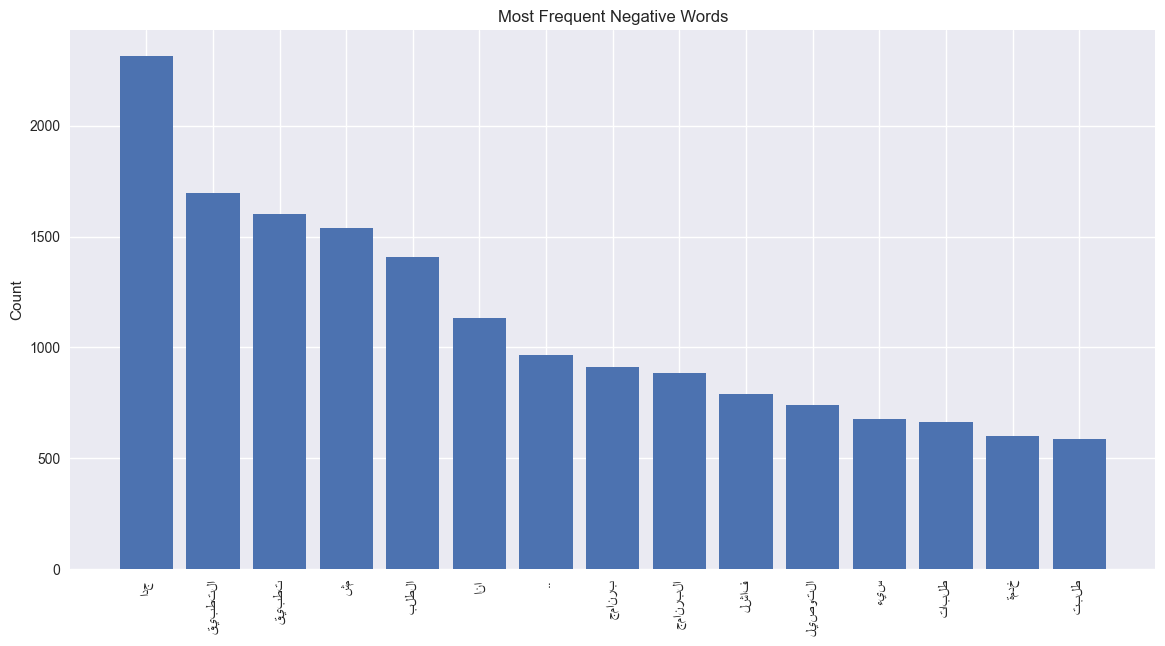

In [21]:
# generate and show a bar chart of the most frequent negative words with their counts.
dilsplay_most_frequent_tokens(most_frequent_negative_words,title='Most Frequent Negative Words')

Negative Reviews


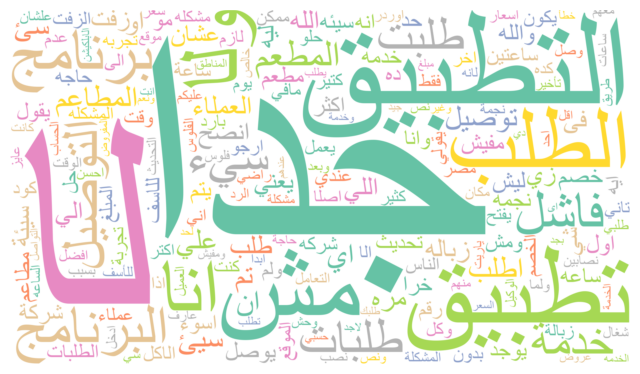

In [22]:
# Display wordcloud of Negative reviews 
print('Negative Reviews')
column_to_wordcloud(df[df['numeric_rating']==-1],'review_description',font_file,arabic_stopwords)

#### Analysis of Positive Reviews 

In [23]:
most_frequent_positive_words=sorted(get_tokens_count(rating=1).items(),reverse=True,key=lambda x : x[-1])[:15]
print(most_frequent_positive_words)

[('جدا', 3792), ('ممتاز', 2476), ('تطبيق', 2171), ('جميل', 1592), ('رائع', 1520), ('برنامج', 1385), ('التطبيق', 1309), ('حلو', 1153), ('البرنامج', 990), ('المطاعم', 875), ('الطلب', 766), ('طلبات', 743), ('التوصيل', 714), ('انا', 712), ('شكرا', 693)]


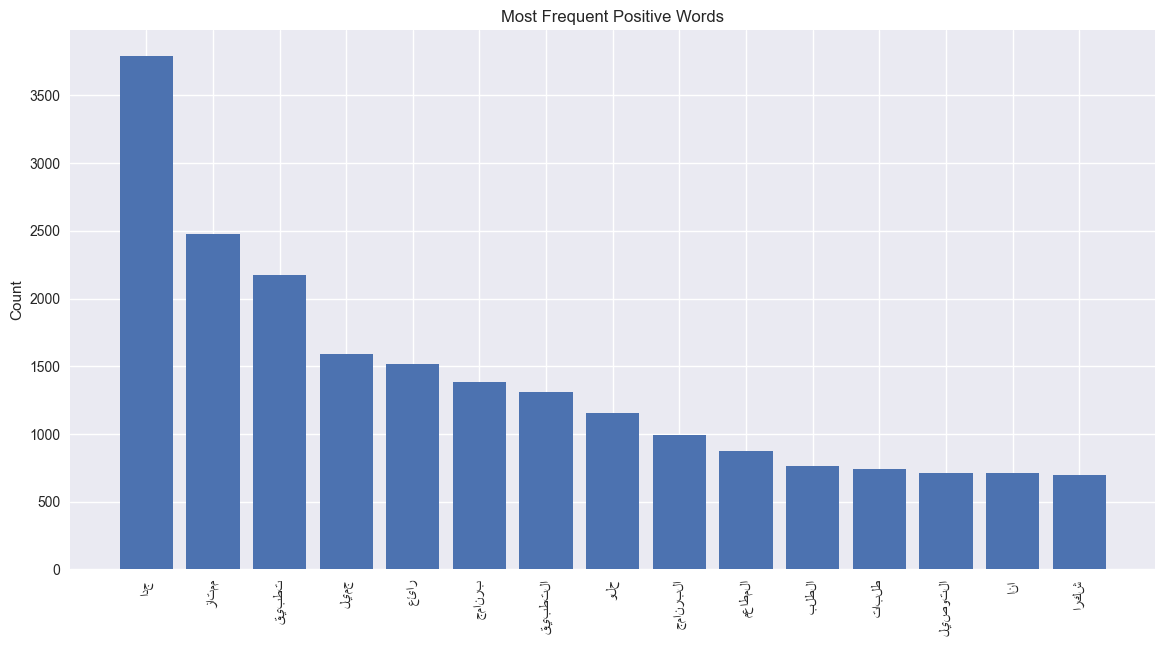

In [24]:
# generate and show a bar chart of the most frequent Positive words with their counts.
dilsplay_most_frequent_tokens(most_frequent_positive_words,title='Most Frequent Positive Words')

Positive Reviews


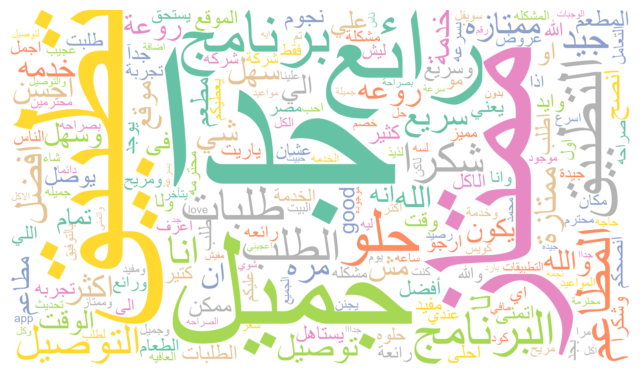

In [25]:
# Display wordcloud of Positive reviews 
print('Positive Reviews')
while 1: 
    try :     
        column_to_wordcloud(df[df['numeric_rating']==1].sample(frac=.3),'review_description',font_file,arabic_stopwords)
        break 
    except : 
        pass 

### Analysis of reviews length

In [26]:
# adding column length of reviews to data 
df['length']=df.review_description.apply(lambda x : len(x))
df 

,review_description,rating,company,numeric_rating,length
0,رائع,positive,talbat,1.0,4
1,برنامج رائع جدا يساعد على تلبيه الاحتياجات بشك...,positive,talbat,1.0,52
2,التطبيق لا يغتح دائما بيعطيني لا يوجد اتصال با...,negative,talbat,-1.0,84
3,لماذا لا يمكننا طلب من ماكدونالدز؟,negative,talbat,-1.0,34
4,البرنامج بيظهر كل المطاعم و مغلقه مع انها بتكو...,negative,talbat,-1.0,75
...,...,...,...,...,...
40041,تجربه جيده بس ينقصها عدم اهتمام خدمة العملاء ب...,neutral,swvl,NaN,111
40042,انا ساكنة بمنطقة الكينج ولا توجد عربيات قبل ال...,negative,swvl,-1.0,62
40043,جيد ولكن لماذا لا توجد خطوط كثيره من المريوطيه...,neutral,swvl,NaN,80
40044,جيدا جدا ...ولكن الاسعار عاليه جدا\n,neutral,swvl,NaN,35


In [27]:
# Calculate the 95th percentile for text length in the 'length' column
length_limit = np.percentile(df['length'], 95)
# Print the length limit where 95% of the text data is shorter than this value
print(f'95% of text is shorter than {length_limit} characters')

95% of text is shorter than 171.0 characters


In [28]:
fig = px.histogram(df, x='length', nbins=50, title='Histogram of Review Lengths')
fig.update_layout(
    xaxis_title='Review Length',
    yaxis_title='Count',
    bargap=0.1
)
fig.show()

In [29]:
fig = px.box(df, y='length', title='Box Plot of Review Lengths')
fig.update_layout(
    yaxis_title='Review Length',
    showlegend=False
)
fig.show()


In [30]:
def clear_outliers(df: pd.DataFrame, column: str) -> pd.DataFrame:
    # Extract the column values as a list
    values = df[column].tolist()
    
    # Calculate the 75th and 25th percentiles of the column values
    upper_limit = np.percentile(values, 75)
    lower_limit = np.percentile(values, 25)
    
    # Calculate the Interquartile Range (IQR)
    iqr = upper_limit - lower_limit
    
    # Define bounds for outliers
    upper_bound = upper_limit + 1.5 * iqr
    lower_bound = lower_limit - 1.5 * iqr
    
    # Filter out the outliers based on the defined bounds
    df_cleaned = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    
    return df_cleaned
cleaned_outliers_data=clear_outliers(df,'length')
cleaned_outliers_data

,review_description,rating,company,numeric_rating,length
0,رائع,positive,talbat,1.0,4
1,برنامج رائع جدا يساعد على تلبيه الاحتياجات بشك...,positive,talbat,1.0,52
2,التطبيق لا يغتح دائما بيعطيني لا يوجد اتصال با...,negative,talbat,-1.0,84
3,لماذا لا يمكننا طلب من ماكدونالدز؟,negative,talbat,-1.0,34
4,البرنامج بيظهر كل المطاعم و مغلقه مع انها بتكو...,negative,talbat,-1.0,75
...,...,...,...,...,...
40041,تجربه جيده بس ينقصها عدم اهتمام خدمة العملاء ب...,neutral,swvl,NaN,111
40042,انا ساكنة بمنطقة الكينج ولا توجد عربيات قبل ال...,negative,swvl,-1.0,62
40043,جيد ولكن لماذا لا توجد خطوط كثيره من المريوطيه...,neutral,swvl,NaN,80
40044,جيدا جدا ...ولكن الاسعار عاليه جدا\n,neutral,swvl,NaN,35


In [31]:
# Calculate the number of outliers in the data by subtracting the number of rows in the cleaned DataFrame 
outliers_count = df.shape[0] - cleaned_outliers_data.shape[0]

print(f'Number of outliers in data: {outliers_count}')

Number of outliers in data: 3352


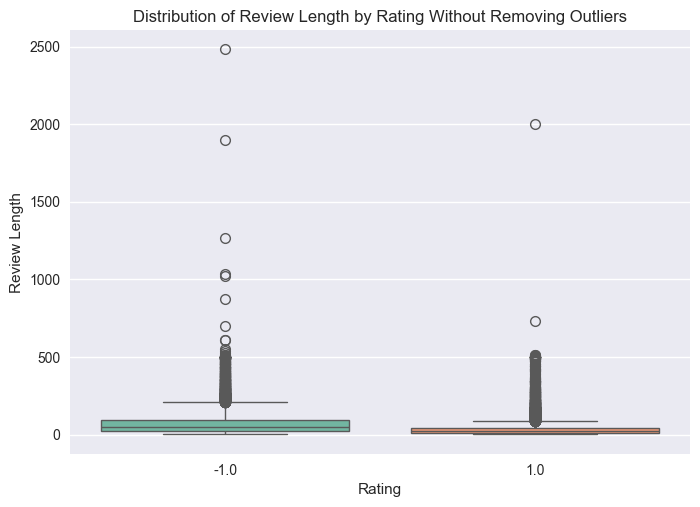

In [32]:
# Create a boxplot to visualize the distribution of review lengths by rating
sns.boxplot(data=df, x='numeric_rating', y='length', palette='Set2')
plt.xlabel('Rating')
plt.ylabel('Review Length')
# Add a title to the plot
plt.title('Distribution of Review Length by Rating Without Removing Outliers')

# Display the plot
plt.show()

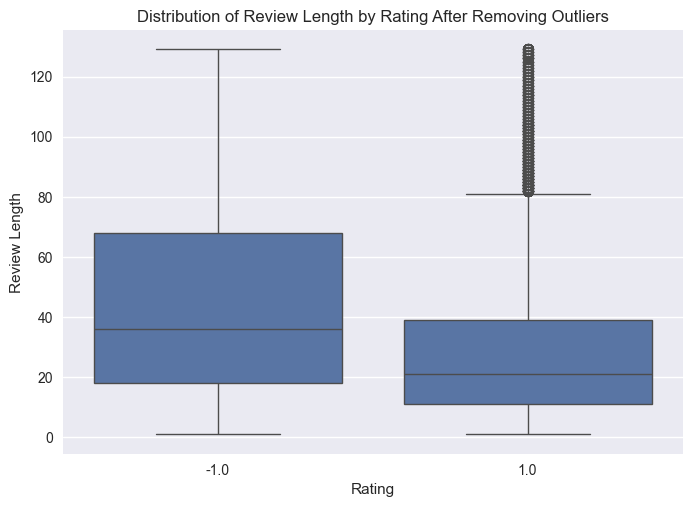

In [33]:
# Create a boxplot to visualize the distribution of review lengths by rating after removing outliers
sns.boxplot(cleaned_outliers_data, x='numeric_rating', y='length')
plt.xlabel('Rating')
plt.ylabel('Review Length')
# Add a title to the plot
plt.title('Distribution of Review Length by Rating After Removing Outliers')

# Display the plot
plt.show()